In [1]:
!pip install transformers datasets accelerate torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-agile-community-rules/sample_submission.csv
/kaggle/input/jigsaw-agile-community-rules/train.csv
/kaggle/input/jigsaw-agile-community-rules/test.csv


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from accelerate import PartialState
from transformers import EarlyStoppingCallback

In [4]:
distributed_state = PartialState()

In [5]:
# Load data
train_df = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/train.csv')

# Combine text fields for each sample
def combine_text_fields(row):
    return f"Comment: {row['body']}\nRule: {row['rule']}\nPositive Example 1: {row['positive_example_1']}\nPositive Example 2: {row['positive_example_2']}\nNegative Example 1: {row['negative_example_1']}\nNegative Example 2: {row['negative_example_2']}"

train_df['combined_text'] = train_df.apply(combine_text_fields, axis=1)

# Split training data for validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['combined_text'].tolist(),
    train_df['rule_violation'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=train_df['rule_violation']
)

In [6]:
class RedditDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=2048):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

In [11]:
# Create a configuration with the desired dropout and classification parameters
model_name = "answerdotai/ModernBERT-base"
config = AutoConfig.from_pretrained(model_name)
config.hidden_dropout_prob = 0.3
config.attention_probs_dropout_prob = 0.3
config.num_labels = 1  # Set num_labels in config
config.problem_type = "regression"  # Set problem_type in config

In [12]:
# Initialize the model with the custom configuration
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

# Create datasets
train_dataset = RedditDataset(train_texts, train_labels, tokenizer)
val_dataset = RedditDataset(val_texts, val_labels, tokenizer)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    auc = roc_auc_score(labels, probs)
    return {"auc": auc}

In [14]:
# Improved training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,  
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=1e-5,
    warmup_ratio=0.1,  
    weight_decay=0.1,  
    max_grad_norm=1.0,  # Add gradient clipping
    lr_scheduler_type="cosine",  # Add cosine scheduling
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",  # Monitor validation loss
    greater_is_better=False,  # Lower loss is better
    report_to="none",
    fp16=True,
    bf16=False,
    local_rank=-1,
    ddp_find_unused_parameters=False,
)

In [15]:
# Fixed CustomTrainer
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.training_losses = []
        self.validation_losses = []
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Compute BCE loss
        loss_fct = torch.nn.BCEWithLogitsLoss()
        loss = loss_fct(logits.view(-1), labels.view(-1))
        
        # Store training loss
        self.training_losses.append(loss.item())
        
        return (loss, outputs) if return_outputs else loss
    
    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix="eval"):
        # Run evaluation
        eval_output = super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)
        
        # Store validation loss
        if "eval_loss" in eval_output:
            self.validation_losses.append(eval_output["eval_loss"])
        
        return eval_output

In [16]:
# Initialize custom trainer with reduced patience
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

/tmp/ipykernel_36/4238308739.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [17]:
# Train the model
trainer.train()

# Get the losses
train_losses = trainer.training_losses
val_losses = trainer.validation_losses

W0928 06:53:15.264000 36 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Auc
1,0.687300,0.697734,0.648167
2,0.634600,0.595160,0.783362
3,0.510100,0.527221,0.830704
4,0.376000,0.737055,0.825000


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

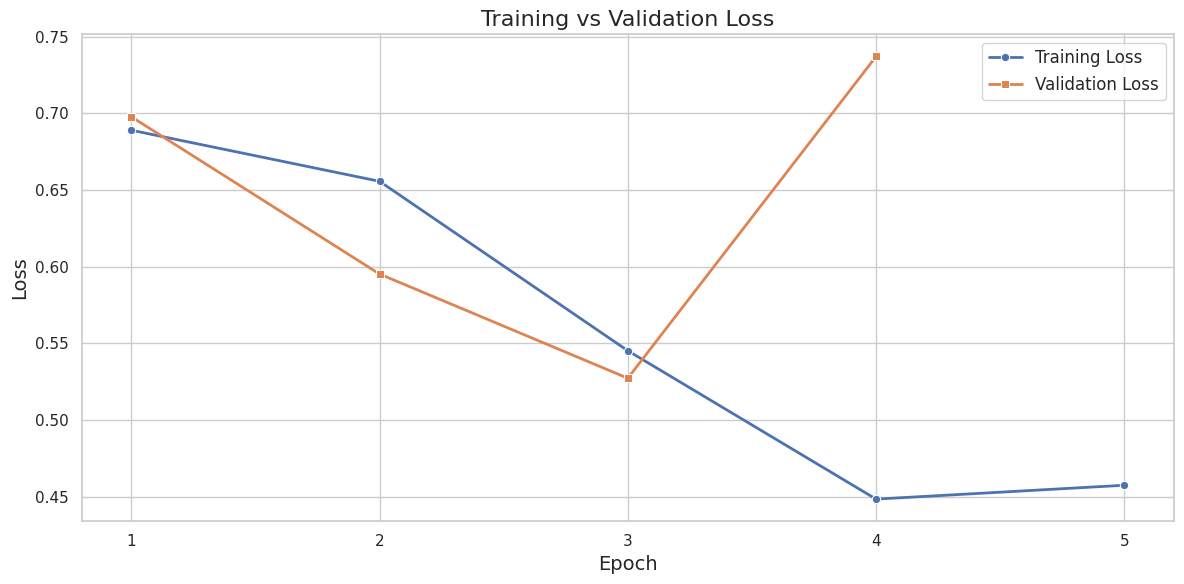

In [18]:
# Plot losses
def plot_losses(train_losses, val_losses):
    # Group training losses by epoch
    epoch_length = len(train_dataset) // training_args.per_device_train_batch_size
    train_losses_per_epoch = [train_losses[i:i+epoch_length] for i in range(0, len(train_losses), epoch_length)]
    avg_train_losses = [np.mean(epoch_losses) for epoch_losses in train_losses_per_epoch]
    
    # Create plot
    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")
    
    # Plot training loss
    sns.lineplot(x=range(1, len(avg_train_losses)+1), y=avg_train_losses, 
                 label='Training Loss', marker='o', linewidth=2)
    
    # Plot validation loss
    sns.lineplot(x=range(1, len(val_losses)+1), y=val_losses, 
                 label='Validation Loss', marker='s', linewidth=2)
    
    plt.title('Training vs Validation Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.xticks(range(1, len(avg_train_losses)+1))
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot the losses
plot_losses(train_losses, val_losses)

In [19]:
def analyze_model_performance(train_losses, val_losses, train_auc_scores=None):
    # Calculate average losses
    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    loss_diff = avg_val_loss - avg_train_loss
    
    print(f"Average Training Loss: {avg_train_loss:.4f}")
    print(f"Average Validation Loss: {avg_val_loss:.4f}")
    print(f"Loss Difference (Val - Train): {loss_diff:.4f}")
    
    # Calculate improvement trends (if we have per-epoch data)
    if len(train_losses) > 1:
        train_improvement = (train_losses[0] - train_losses[-1]) / train_losses[0]
        val_improvement = (val_losses[0] - val_losses[-1]) / val_losses[0]
        print(f"Training Loss Improvement: {train_improvement*100:.1f}%")
        print(f"Validation Loss Improvement: {val_improvement*100:.1f}%")
    
    # More nuanced analysis
    print("\nModel Analysis:")
    
    # Case 1: Both losses are high and similar
    if avg_train_loss > 0.5 and abs(loss_diff) < 0.05:
        print("Status: UNDERFITTING")
        print("Reasons: High training loss indicates model hasn't learned patterns well")
        print("Recommendations: Increase model capacity, train longer, reduce regularization")
    
    # Case 2: Training loss much lower than validation loss
    elif loss_diff > 0.1:
        if avg_train_loss < 0.3:
            print("Status: SEVERE OVERFITTING")
            print("Reasons: Very low training loss but high validation loss")
            print("Recommendations: Add regularization, dropout, reduce model complexity")
        else:
            print("Status: MODERATE OVERFITTING")
            print("Reasons: Training loss significantly lower than validation loss")
            print("Recommendations: Add regularization, early stopping, data augmentation")
    
    # Case 3: Validation loss lower than training loss (common with dropout)
    elif loss_diff < -0.05:
        if avg_train_loss < 0.4:
            print("Status: GOOD FIT (with regularization)")
            print("Reasons: Low losses with validation slightly lower than training (normal with dropout)")
            print("Recommendations: Continue training, monitor for overfitting")
        else:
            print("Status: UNDER-OPTIMIZED")
            print("Reasons: Losses are still relatively high")
            print("Recommendations: Train longer, increase learning rate, or model capacity")
    
    # Case 4: Both losses moderate and similar
    else:
        if avg_train_loss < 0.4:
            print("Status: GOOD FIT")
            print("Reasons: Moderate losses with good generalization")
            print("Recommendations: Fine-tune hyperparameters, consider early stopping")
        else:
            print("Status: NEEDS IMPROVEMENT")
            print("Reasons: Losses are moderate but could be lower")
            print("Recommendations: Train longer, adjust learning rate, or model architecture")
    
    # Additional recommendations based on AUC if available
    if train_auc_scores:
        final_auc = train_auc_scores[-1]
        print(f"\nFinal AUC: {final_auc:.4f}")
        if final_auc < 0.7:
            print("AUC is low - model needs significant improvement")
        elif final_auc < 0.8:
            print("AUC is moderate - model has room for improvement")
        elif final_auc < 0.9:
            print("AUC is good - model is performing well")
        else:
            print("AUC is excellent - model is performing very well")